In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.signal import resample

import warnings
warnings.filterwarnings("ignore")


In [2]:
!pip install --upgrade seaborn

In [3]:
pip install pycrostates

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Define frequency bands
frequency_bands = {
    # 'delta': (0.5, 4),
    # 'theta': (4, 8),
    # 'alpha': (8, 13),
    'beta': (13, 30),
    # 'gamma': (30, 45)
}

for band_name, (l_freq, h_freq) in frequency_bands.items():
    print(f"{band_name} Band - Low freq = {l_freq} Hz and High freq =  {h_freq} Hz")

beta Band - Low freq = 13 Hz and High freq =  30 Hz


# Pre-Processing Alzheimer Patients

In [5]:
# Alzheimer's EEG files (Filtered Derivatives)
alzheimer_files = [
    '/kaggle/input/alzheimerderivatives/sub-001_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-002_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-003_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-004_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-005_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-006_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-007_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-008_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-009_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-010_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-011_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-012_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-013_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-014_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-015_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-016_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-017_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-018_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-019_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-020_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-021_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-022_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-023_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-024_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-025_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-026_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-027_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-028_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-029_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-030_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-031_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-032_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-033_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-034_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-035_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-036_task-eyesclosed_eeg.set',

]

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mne.io import read_raw_eeglab

from pycrostates.cluster import ModKMeans
from pycrostates.datasets import lemon
from pycrostates.io import ChData
from pycrostates.preprocessing import extract_gfp_peaks, resample

## Group-level analysis from individual clusters

In [7]:
patients_ad = alzheimer_files
durations_ad = []

individual_cluster_centers = list()

for file_path in patients_ad:
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    durations_ad.append(raw.times[-1])
    raw.pick("eeg")
    raw.crop(30,40)  # Cut each patient data from 60 seconds to 90 seconds (30 seconds)
    raw.set_eeg_reference("average")
    # extract GFP peaks
    gfp_peaks = extract_gfp_peaks(raw, min_peak_distance=20)
    ModK = ModKMeans(n_clusters=4, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=-1)
    individual_cluster_centers.append(ModK.cluster_centers_)
    
group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [8]:
min_duration = min(durations_ad)
min_duration

599.798

## Group level clustering

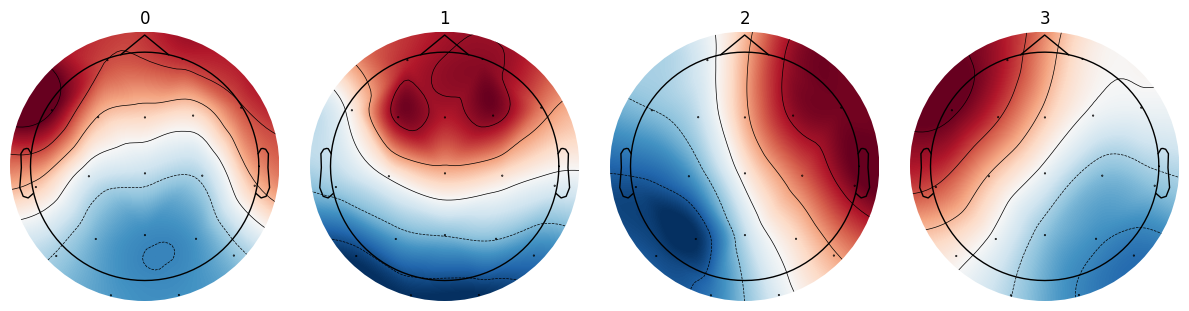

In [9]:
# group level clustering
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=-1)
ModK.plot();

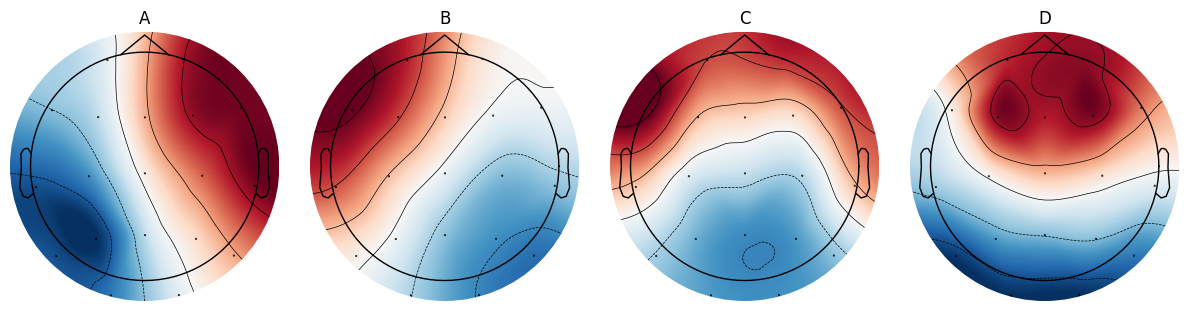

In [10]:
ModK.reorder_clusters(order=[2, 3, 0, 1])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])
# Plot and modify
fig = ModK.plot();  # Generate the plot
fig.savefig("group_level_clustering_AD.png", dpi=300)  # Save the plot as a PNG file

In [11]:
subject_ids = np.arange(1, len(alzheimer_files)+1) # total 29 patients AD

##  Microstate Parameters AD

In [12]:
ms_data = list()
length = 0
transition_prob = pd.DataFrame()

for file_path, subject_id in zip(patients_ad, subject_ids):  # Ensure subject IDs align with file paths
    # Load Data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.pick("eeg")
    raw.crop(0, 479.098)  # Crop the dataset to speed up computation taking 9 minutes
    raw.set_eeg_reference("average")
    raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., alpha band)
    
    # Define epoch duration (5 seconds) and create epochs
    epoch_duration = 5  # seconds
    epochs = mne.make_fixed_length_epochs(raw, duration=epoch_duration)
    epochs.load_data()
    
    for i in range(len(epochs)):
    
        # Perform microstate segmentation on the entire Epochs object
        # segmentation = ModK.predict(epochs[i] , factor=10, half_window_size=8)  # Perform microstate segmentation
        segmentation = ModK.predict(epochs[i])  # Perform microstate segmentation
    
        # Process segmentation results to compute microstate parameters
        parameters = segmentation.compute_parameters()  # Compute parameters for all epochs
    
        # Compute transition probabilities
        T_observed = segmentation.compute_transition_matrix()

        # Create a DataFrame for the transition matrix and add it to single_row_df
        transition_row = pd.DataFrame([pd.DataFrame(T_observed).values.flatten()])
        transition_prob = pd.concat([transition_prob, transition_row], ignore_index=True)
        
        # parameters["subject_id"] = subject_id
        ms_data.append(parameters)
    

# Convert `ms_data` to a more structured format like a DataFrame (optional, for analysis)
import pandas as pd
ms_data_df = pd.DataFrame(ms_data)


In [13]:
# TP = segmentation.compute_transition_matrix()
# TP = pd.DataFrame(TP, index=["A", "B", "C", "D"], columns=["A", "B", "C", "D"])

# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Plotting heatmap
# plt.figure(figsize=(6,5))
# sns.heatmap(TP, annot=True, cmap="Blues", fmt=".3f", linewidths=0.7, annot_kws={"size": 15})

# # Adjusting font sizes
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# # plt.title("Transition Probabilities(AD)", fontsize=16)

# plt.show()

In [14]:
# Rename columns and index
columns = ['A', 'B', 'C', 'D']
index = ['A', 'B', 'C', 'D']

# Create a list of column names
new_columns = []
for i in columns:
    for j in columns:
        new_columns.append(f"{i}_{j}")

In [15]:
transition_prob.columns = new_columns

transition_prob

,A_A,A_B,A_C,A_D,B_A,B_B,B_C,B_D,C_A,C_B,C_C,C_D,D_A,D_B,D_C,D_D
0,0.0,0.351852,0.333333,0.314815,0.493056,0.0,0.326389,0.180556,0.322034,0.327684,0.0,0.350282,0.239130,0.210145,0.550725,0.0
1,0.0,0.331361,0.331361,0.337278,0.482270,0.0,0.361702,0.156028,0.264865,0.335135,0.0,0.400000,0.346405,0.143791,0.509804,0.0
2,0.0,0.315217,0.358696,0.326087,0.538922,0.0,0.275449,0.185629,0.237288,0.395480,0.0,0.367232,0.333333,0.250000,0.416667,0.0
3,0.0,0.311765,0.352941,0.335294,0.520548,0.0,0.342466,0.136986,0.270718,0.331492,0.0,0.397790,0.302013,0.221477,0.476510,0.0
4,0.0,0.339623,0.264151,0.396226,0.458647,0.0,0.360902,0.180451,0.266272,0.289941,0.0,0.443787,0.333333,0.185185,0.481481,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.0,0.437908,0.215686,0.346405,0.444444,0.0,0.312500,0.243056,0.377193,0.350877,0.0,0.271930,0.394958,0.302521,0.302521,0.0
2181,0.0,0.373333,0.226667,0.400000,0.503759,0.0,0.218045,0.278195,0.303571,0.375000,0.0,0.321429,0.360902,0.270677,0.368421,0.0
2182,0.0,0.428571,0.204082,0.367347,0.427481,0.0,0.328244,0.244275,0.265487,0.292035,0.0,0.442478,0.451852,0.259259,0.288889,0.0
2183,0.0,0.388489,0.330935,0.280576,0.385185,0.0,0.266667,0.348148,0.284483,0.310345,0.0,0.405172,0.402985,0.335821,0.261194,0.0


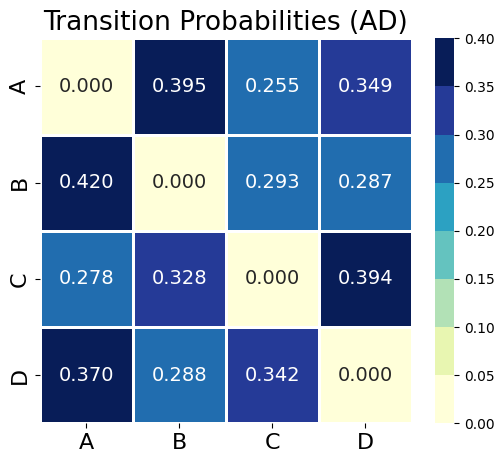

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


avg_transition = transition_prob.mean()

# Reshape into a 4x4 transition matrix
states = ["A", "B", "C", "D"]
transition_matrix = pd.DataFrame(
    avg_transition.values.reshape(4, 4),
    index=states,
    columns=states
)

# Define custom color levels at every 0.05 step
levels = np.arange(0, 0.45, 0.05)  # From 0 to slightly above 0.42 in 0.05 steps
cmap = plt.get_cmap("YlGnBu", len(levels) - 1)  # Discrete colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Apply color boundaries

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    transition_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=0.8,
    annot_kws={"size": 14}, norm=norm, cbar_kws={"ticks": levels}
)

# Adjust font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transition Probabilities (AD)", fontsize=19)

# Save the plot
plt.savefig("Transition_Probabilities_AD.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
avg_transition

A_A    0.000000
A_B    0.395319
A_C    0.255465
A_D    0.349216
B_A    0.419860
B_B    0.000000
B_C    0.292870
B_D    0.287270
C_A    0.278349
C_B    0.327779
C_C    0.000000
C_D    0.393872
D_A    0.370117
D_B    0.287920
D_C    0.341962
D_D    0.000000
dtype: float64

In [18]:
ms_data_df = pd.concat([ms_data_df, transition_prob], axis=1)
ms_data_df = ms_data_df.drop(["A_A","B_B","C_C","D_D"], axis=1)

In [19]:
ms_data_df

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,A_D,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C
0,0.572685,0.066796,32.661290,0.216935,0.006642,0.625772,0.073567,29.032258,0.185081,0.006375,...,0.314815,0.493056,0.326389,0.180556,0.322034,0.327684,0.350282,0.239130,0.210145,0.550725
1,0.605374,0.094844,34.068136,0.248096,0.007282,0.601817,0.059994,28.256513,0.164729,0.005830,...,0.337278,0.482270,0.361702,0.156028,0.264865,0.335135,0.400000,0.346405,0.143791,0.509804
2,0.599487,0.079159,36.903329,0.236262,0.006402,0.616937,0.080912,33.493783,0.212194,0.006335,...,0.326087,0.538922,0.275449,0.185629,0.237288,0.395480,0.367232,0.333333,0.250000,0.416667
3,0.558343,0.061351,34.040849,0.214257,0.006294,0.590509,0.056853,29.235082,0.168602,0.005767,...,0.335294,0.520548,0.342466,0.136986,0.270718,0.331492,0.397790,0.302013,0.221477,0.476510
4,0.568635,0.043385,32.102729,0.180979,0.005638,0.561140,0.026623,26.685393,0.144462,0.005414,...,0.396226,0.458647,0.360902,0.180451,0.266272,0.289941,0.443787,0.333333,0.185185,0.481481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.696841,0.180781,30.998390,0.324879,0.010481,0.734486,0.164522,28.985507,0.271337,0.009361,...,0.346405,0.444444,0.312500,0.243056,0.377193,0.350877,0.271930,0.394958,0.302521,0.302521
2181,0.698570,0.185360,30.060120,0.309018,0.010280,0.671786,0.091374,26.853707,0.202004,0.007522,...,0.400000,0.503759,0.218045,0.278195,0.303571,0.375000,0.321429,0.360902,0.270677,0.368421
2182,0.699302,0.153924,29.601289,0.294805,0.009959,0.714519,0.134256,26.379380,0.213451,0.008092,...,0.367347,0.427481,0.328244,0.244275,0.265487,0.292035,0.442478,0.451852,0.259259,0.288889
2183,0.715794,0.216387,27.855711,0.326253,0.011712,0.701600,0.124235,27.054108,0.222445,0.008222,...,0.280576,0.385185,0.266667,0.348148,0.284483,0.310345,0.405172,0.402985,0.335821,0.261194


In [20]:
ms_data_df['label'] = 1  # 1 For alzheimer

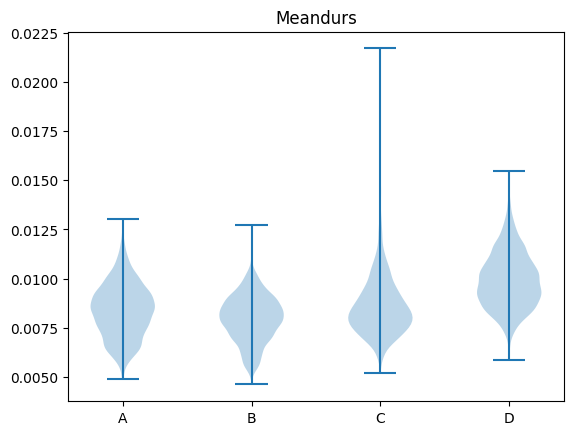

In [21]:
import seaborn as sns
data = [
    [parameters['A_meandurs'], parameters['B_meandurs'], parameters['C_meandurs'], parameters['D_meandurs']]
    for parameters in ms_data
]

plt.violinplot(np.array(data))
# sns.violinplot(np.array(data),fill=False,split=True, inner="quart")
# plt.boxplot(np.array(data), showmeans=True, meanline=True)
plt.title("Meandurs")
plt.xticks(
    ticks=range(1, len(ModK.cluster_names) + 1),
    labels=ModK.cluster_names,
)
plt.show()

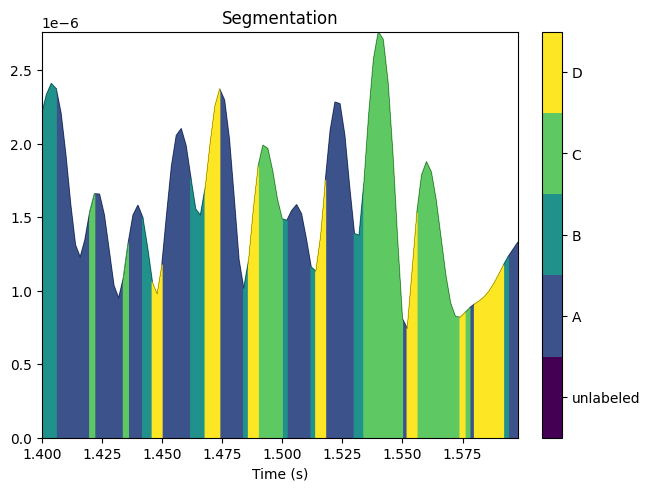

In [22]:
#for segmentation plot of a single patient
raw = mne.io.read_raw_eeglab("/kaggle/input/alzheimerderivatives/sub-001_task-eyesclosed_eeg.set", preload=True)
raw.pick("eeg")
raw.crop(0, 479.098)  # Crop the dataset to speed up computation taking 9 minutes
raw.set_eeg_reference("average")
raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., alpha band)
segmentation = ModK.predict(raw)
fig = segmentation.plot(tmin=1.4, tmax=1.6);
# Increase figure size
fig.set_size_inches(12, 8)  # Width: 12 inches, Height: 8 inches (adjust as needed)

# Save the plot to a file
fig.savefig("segmentation_plot_AD.png", dpi=300)  # Save with high resolution (300 dpi)

# Optional: Show the plot
plt.show()


In [23]:
epochs[1].times[-1]

4.998

# **Pre-Processing Normal Patient**

In [24]:
# Normal EEG files (Filtered Derivatives)
normal_files = [
    '/kaggle/input/alzheimerderivatives/sub-037_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-038_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-039_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-040_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-041_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-042_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-043_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-044_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-045_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-046_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-047_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-048_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-049_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-050_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-051_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-052_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-053_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-054_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-055_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-056_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-057_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-058_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-059_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-060_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-061_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-062_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-063_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-064_task-eyesclosed_eeg.set',
    # '/kaggle/input/alzheimerderivatives/sub-065_task-eyesclosed_eeg.set',
]

## Group-level analysis from individual clusters HC

In [25]:
patients_n = normal_files
durations = []
# individual_gfp_peaks = list()
individual_cluster_centers = list()

for file_path in patients_n:
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    durations.append(raw.times[-1])
    raw.pick("eeg")
    raw.crop(30,40)  # Cut each patient data from 60 seconds to 90 seconds (30 seconds)
    raw.set_eeg_reference("average")
    # extract GFP peaks
    gfp_peaks = extract_gfp_peaks(raw, min_peak_distance=20)
    ModK = ModKMeans(n_clusters=4, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=-1)
    individual_cluster_centers.append(ModK.cluster_centers_)
    # individual_gfp_peaks.append(gfp_peaks.get_data())
    # print(file_path)
group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

In [26]:
min_duration = min(durations)
min_duration

753.038

## Group level clustering HC

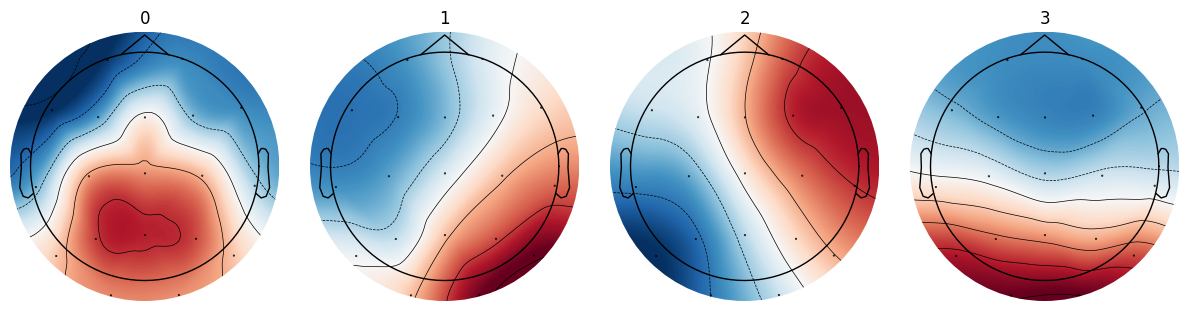

In [27]:
# group level clustering
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=-1)
ModK.plot();

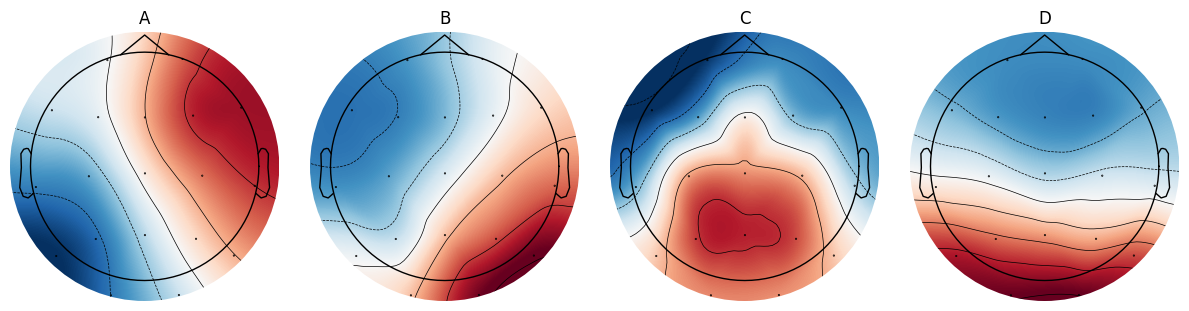

In [28]:
ModK.reorder_clusters(order=[2, 1, 0, 3])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])
# Plot and modify
fig = ModK.plot();  # Generate the plot
fig.savefig("group_level_clustering_HC.png", dpi=300)  # Save the plot as a PNG file

In [29]:
subject_ids = np.arange(1, len(normal_files)+1)

## Microstate Parameters HC

In [30]:
ms_data_hc = list()
length = 0
transition_prob_hc = pd.DataFrame()

for file_path, subject_id in zip(patients_n, subject_ids):  # Ensure subject IDs align with file paths
    # Load Data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.pick("eeg")
    raw.crop(0, 479.098)  # Crop the dataset to speed up computation
    raw.set_eeg_reference("average")
    raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., theta band)
    
    # Define epoch duration (5 seconds) and create epochs
    epoch_duration = 5  # seconds
    epochs = mne.make_fixed_length_epochs(raw, duration=epoch_duration)
    epochs.load_data()
    
    for i in range(len(epochs)):
    
        # Perform microstate segmentation on the entire Epochs object
        # segmentation = ModK.predict(epochs[i] , factor=10, half_window_size=8)  # Perform microstate segmentation
        segmentation = ModK.predict(epochs[i])  # Perform microstate segmentation
    
        # Process segmentation results to compute microstate parameters
        parameters = segmentation.compute_parameters()  # Compute parameters for all epochs

        # Compute transition probabilities
        T_observed = segmentation.compute_transition_matrix()

        # Create a DataFrame for the transition matrix and add it to single_row_df
        transition_row = pd.DataFrame([pd.DataFrame(T_observed).values.flatten()])
        transition_prob_hc = pd.concat([transition_prob_hc, transition_row], ignore_index=True)

        # parameters["subject_id"] = subject_id
        ms_data_hc.append(parameters)
    

# Convert `ms_data` to a more structured format like a DataFrame (optional, for analysis)
import pandas as pd
ms_data_hc_df = pd.DataFrame(ms_data_hc)


In [31]:
transition_prob_hc.columns = new_columns

transition_prob_hc

,A_A,A_B,A_C,A_D,B_A,B_B,B_C,B_D,C_A,C_B,C_C,C_D,D_A,D_B,D_C,D_D
0,0.0,0.365672,0.313433,0.320896,0.377358,0.0,0.308176,0.314465,0.272727,0.504132,0.0,0.223140,0.341667,0.408333,0.250000,0.0
1,0.0,0.351351,0.297297,0.351351,0.410256,0.0,0.275641,0.314103,0.278689,0.426230,0.0,0.295082,0.364964,0.379562,0.255474,0.0
2,0.0,0.425676,0.304054,0.270270,0.373333,0.0,0.240000,0.386667,0.312500,0.357143,0.0,0.330357,0.429630,0.348148,0.222222,0.0
3,0.0,0.460432,0.244604,0.294964,0.378205,0.0,0.314103,0.307692,0.408696,0.260870,0.0,0.330435,0.259843,0.488189,0.251969,0.0
4,0.0,0.384615,0.251748,0.363636,0.369128,0.0,0.295302,0.335570,0.300000,0.308333,0.0,0.391667,0.348993,0.382550,0.268456,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.0,0.432624,0.269504,0.297872,0.365385,0.0,0.314103,0.320513,0.298387,0.443548,0.0,0.258065,0.382114,0.325203,0.292683,0.0
2181,0.0,0.273885,0.292994,0.433121,0.492754,0.0,0.347826,0.159420,0.338235,0.250000,0.0,0.411765,0.287671,0.424658,0.287671,0.0
2182,0.0,0.373418,0.240506,0.386076,0.431655,0.0,0.244604,0.323741,0.362832,0.283186,0.0,0.353982,0.397260,0.321918,0.280822,0.0
2183,0.0,0.416667,0.256410,0.326923,0.350000,0.0,0.293750,0.356250,0.342105,0.289474,0.0,0.368421,0.406667,0.413333,0.180000,0.0


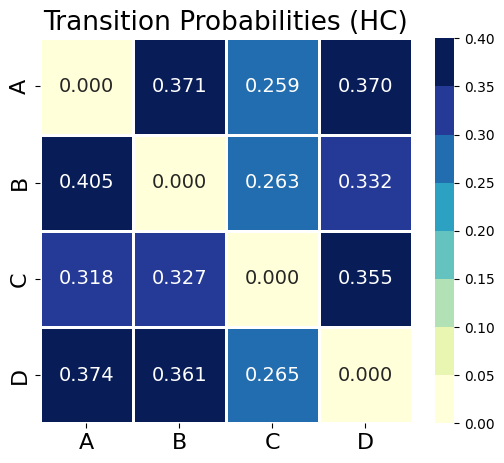

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avg_transition = transition_prob_hc.mean()

# Reshape into a 4x4 transition matrix
states = ["A", "B", "C", "D"]
transition_matrix = pd.DataFrame(
    avg_transition.values.reshape(4, 4),
    index=states,
    columns=states
)

# Define custom color levels at every 0.05 step
levels = np.arange(0, 0.45, 0.05)  # From 0 to slightly above 0.42 in 0.05 steps
cmap = plt.get_cmap("YlGnBu", len(levels) - 1)  # Discrete colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Apply color boundaries

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    transition_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=0.8,
    annot_kws={"size": 14}, norm=norm, cbar_kws={"ticks": levels}
)

# Adjust font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transition Probabilities (HC)", fontsize=19)

# Save the plot
plt.savefig("Transition_Probabilities_HC.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
ms_data_hc_df = pd.concat([ms_data_hc_df, transition_prob_hc], axis=1)
ms_data_hc_df = ms_data_hc_df.drop(["A_A","B_B","C_C","D_D"], axis=1)

In [34]:
ms_data_hc_df

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,A_D,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C
0,0.600326,0.081817,27.272727,0.213737,0.007837,0.660988,0.188130,32.121212,0.332929,0.010365,...,0.320896,0.377358,0.308176,0.314465,0.272727,0.504132,0.223140,0.341667,0.408333,0.250000
1,0.581937,0.076772,29.671211,0.213312,0.007189,0.646213,0.187359,31.275060,0.309142,0.009885,...,0.351351,0.410256,0.275641,0.314103,0.278689,0.426230,0.295082,0.364964,0.379562,0.255474
2,0.595816,0.103990,29.835803,0.245094,0.008215,0.658140,0.182944,30.036043,0.322787,0.010747,...,0.270270,0.373333,0.240000,0.386667,0.312500,0.357143,0.330357,0.429630,0.348148,0.222222
3,0.581969,0.097843,27.911647,0.232129,0.008317,0.629176,0.137910,31.325301,0.291566,0.009308,...,0.294964,0.378205,0.314103,0.307692,0.408696,0.260870,0.330435,0.259843,0.488189,0.251969
4,0.604568,0.099406,28.668805,0.220930,0.007706,0.620968,0.116572,30.072173,0.254611,0.008467,...,0.363636,0.369128,0.295302,0.335570,0.300000,0.308333,0.391667,0.348993,0.382550,0.268456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.620144,0.095939,28.301887,0.226014,0.007986,0.620528,0.167490,31.312726,0.321156,0.010256,...,0.297872,0.365385,0.314103,0.320513,0.298387,0.443548,0.258065,0.382114,0.325203,0.292683
2181,0.587905,0.083664,31.437725,0.248298,0.007898,0.586310,0.086487,27.833400,0.213056,0.007655,...,0.433121,0.492754,0.347826,0.159420,0.338235,0.250000,0.411765,0.287671,0.424658,0.287671
2182,0.631987,0.153850,31.953376,0.306672,0.009597,0.607892,0.088646,27.934084,0.232717,0.008331,...,0.386076,0.431655,0.244604,0.323741,0.362832,0.283186,0.353982,0.397260,0.321918,0.280822
2183,0.623362,0.126112,31.287605,0.275170,0.008795,0.642148,0.174063,32.089852,0.317288,0.009888,...,0.326923,0.350000,0.293750,0.356250,0.342105,0.289474,0.368421,0.406667,0.413333,0.180000


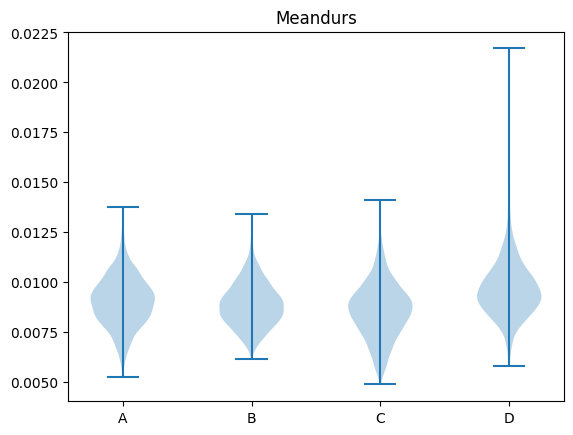

In [35]:
data = [
    [parameters['A_meandurs'], parameters['B_meandurs'], parameters['C_meandurs'], parameters['D_meandurs']]
    for parameters in ms_data_hc
]

plt.violinplot(np.array(data))
# plt.boxplot(np.array(data), showmeans=True, meanline=True)
plt.title("Meandurs")
plt.xticks(
    ticks=range(1, len(ModK.cluster_names) + 1),
    labels=ModK.cluster_names,
)
plt.show()

In [36]:
ms_data_hc_df['label'] = 0  # 0 For normal

In [37]:
ms_data_hc_df

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C,label
0,0.600326,0.081817,27.272727,0.213737,0.007837,0.660988,0.188130,32.121212,0.332929,0.010365,...,0.377358,0.308176,0.314465,0.272727,0.504132,0.223140,0.341667,0.408333,0.250000,0
1,0.581937,0.076772,29.671211,0.213312,0.007189,0.646213,0.187359,31.275060,0.309142,0.009885,...,0.410256,0.275641,0.314103,0.278689,0.426230,0.295082,0.364964,0.379562,0.255474,0
2,0.595816,0.103990,29.835803,0.245094,0.008215,0.658140,0.182944,30.036043,0.322787,0.010747,...,0.373333,0.240000,0.386667,0.312500,0.357143,0.330357,0.429630,0.348148,0.222222,0
3,0.581969,0.097843,27.911647,0.232129,0.008317,0.629176,0.137910,31.325301,0.291566,0.009308,...,0.378205,0.314103,0.307692,0.408696,0.260870,0.330435,0.259843,0.488189,0.251969,0
4,0.604568,0.099406,28.668805,0.220930,0.007706,0.620968,0.116572,30.072173,0.254611,0.008467,...,0.369128,0.295302,0.335570,0.300000,0.308333,0.391667,0.348993,0.382550,0.268456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.620144,0.095939,28.301887,0.226014,0.007986,0.620528,0.167490,31.312726,0.321156,0.010256,...,0.365385,0.314103,0.320513,0.298387,0.443548,0.258065,0.382114,0.325203,0.292683,0
2181,0.587905,0.083664,31.437725,0.248298,0.007898,0.586310,0.086487,27.833400,0.213056,0.007655,...,0.492754,0.347826,0.159420,0.338235,0.250000,0.411765,0.287671,0.424658,0.287671,0
2182,0.631987,0.153850,31.953376,0.306672,0.009597,0.607892,0.088646,27.934084,0.232717,0.008331,...,0.431655,0.244604,0.323741,0.362832,0.283186,0.353982,0.397260,0.321918,0.280822,0
2183,0.623362,0.126112,31.287605,0.275170,0.008795,0.642148,0.174063,32.089852,0.317288,0.009888,...,0.350000,0.293750,0.356250,0.342105,0.289474,0.368421,0.406667,0.413333,0.180000,0


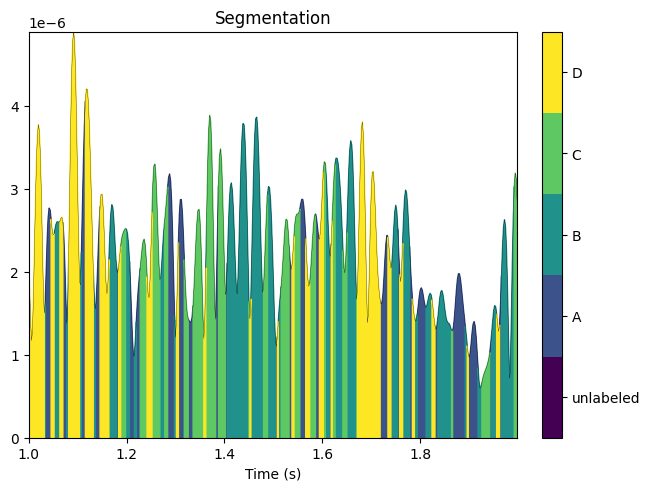

In [38]:
#for segmentation plot of a single patient
raw = mne.io.read_raw_eeglab("/kaggle/input/alzheimerderivatives/sub-040_task-eyesclosed_eeg.set", preload=True)
raw.pick("eeg")
raw.crop(0, 479.098)  # Crop the dataset to speed up computation taking 9 minutes
raw.set_eeg_reference("average")
raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., alpha band)
segmentation = ModK.predict(raw)
fig = segmentation.plot(tmin=1, tmax=2);
# Increase figure size
fig.set_size_inches(12, 8)  # Width: 12 inches, Height: 8 inches (adjust as needed)

# Save the plot to a file
fig.savefig("segmentation_plot_HC.png", dpi=300)  # Save with high resolution (300 dpi)

# Optional: Show the plot
plt.show()


# **Pre-Processing Dementia Patient**

In [39]:
# Dementia EEG files (Filtered Derivatives)
dementia_files = [
    '/kaggle/input/alzheimerderivatives/sub-066_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-067_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-068_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-069_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-070_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-071_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-072_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-073_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-074_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-075_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-076_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-077_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-078_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-079_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-080_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-081_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-082_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-083_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-084_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-085_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-086_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-087_task-eyesclosed_eeg.set',
    '/kaggle/input/alzheimerderivatives/sub-088_task-eyesclosed_eeg.set',
 ]

## Group-level analysis from individual clusters FTD

In [40]:
patients_f = dementia_files
durations = []
# individual_gfp_peaks = list()
individual_cluster_centers = list()

for file_path in patients_f:
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    durations.append(raw.times[-1])
    raw.pick("eeg")
    raw.crop(30, 40)  # Cut each patient data from 60 seconds to 90 seconds (30 seconds)
    raw.set_eeg_reference("average")
    # extract GFP peaks
    gfp_peaks = extract_gfp_peaks(raw, min_peak_distance=20)
    ModK = ModKMeans(n_clusters=4, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=-1)
    individual_cluster_centers.append(ModK.cluster_centers_)
    # individual_gfp_peaks.append(gfp_peaks.get_data())
    # print(file_path)
group_cluster_centers = np.vstack(individual_cluster_centers).T
group_cluster_centers = ChData(group_cluster_centers, ModK.info)

In [41]:
min_duration = min(durations)
min_duration

479.098

## Group level clustering FTD

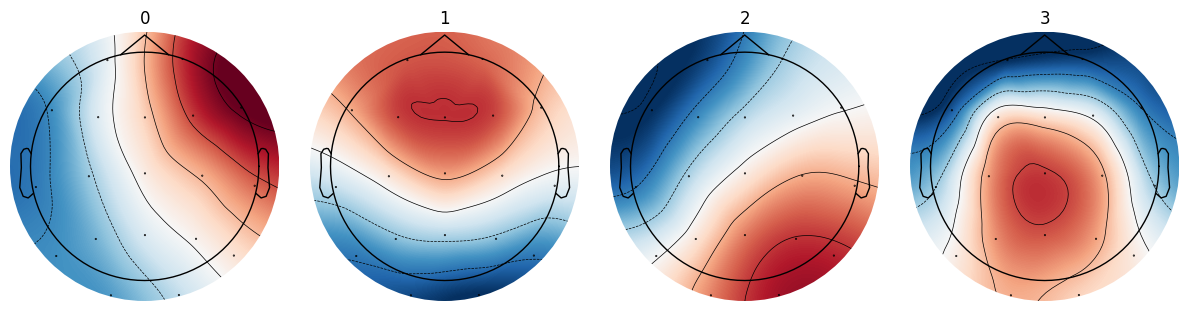

In [42]:
# group level clustering
ModK = ModKMeans(n_clusters=4, random_state=42)
ModK.fit(group_cluster_centers, n_jobs=-1)
ModK.plot();

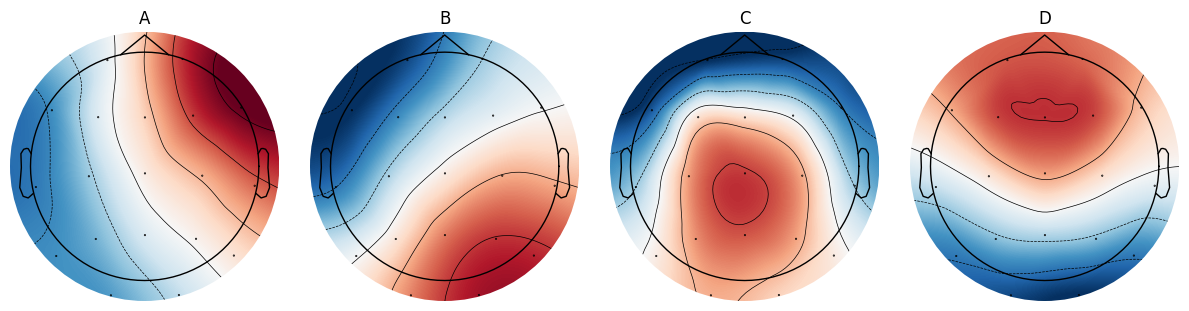

In [43]:
ModK.reorder_clusters(order=[0, 2, 3, 1])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])
# Plot and modify
fig = ModK.plot();  # Generate the plot
fig.savefig("group_level_clustering_FTD.png", dpi=300)  # Save the plot as a PNG file

In [44]:
subject_ids = np.arange(1, len(dementia_files)+1)

## Microstate parameters Dementia

In [45]:
ms_data_f = list()
length = 0
transition_prob_f = pd.DataFrame()

for file_path, subject_id in zip(patients_f, subject_ids):  # Ensure subject IDs align with file paths
    # Load Data
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw.pick("eeg")
    raw.crop(0, 479.098)  # Crop the dataset to speed up computation
    raw.set_eeg_reference("average")
    raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., theta band)
    
    # Define epoch duration (5 seconds) and create epochs
    epoch_duration = 5  # seconds
    epochs = mne.make_fixed_length_epochs(raw, duration=epoch_duration)
    epochs.load_data()
    
    for i in range(len(epochs)):
    
        # Perform microstate segmentation on the entire Epochs object
        # segmentation = ModK.predict(epochs[i] , factor=10, half_window_size=8)  # Perform microstate segmentation
        segmentation = ModK.predict(epochs[i])  # Perform microstate segmentation
    
        # Process segmentation results to compute microstate parameters
        parameters = segmentation.compute_parameters()  # Compute parameters for all epochs

        # Compute transition probabilities
        T_observed = segmentation.compute_transition_matrix()

        # Create a DataFrame for the transition matrix and add it to single_row_df
        transition_row = pd.DataFrame([pd.DataFrame(T_observed).values.flatten()])
        transition_prob_f = pd.concat([transition_prob_f, transition_row], ignore_index=True)
    
        # parameters["subject_id"] = subject_id
        ms_data_f.append(parameters)
    

# Convert `ms_data` to a more structured format like a DataFrame (optional, for analysis)
import pandas as pd
ms_data_f_df = pd.DataFrame(ms_data_f)


In [46]:
transition_prob_f.columns = new_columns

ms_data_f_df = pd.concat([ms_data_f_df, transition_prob_f], axis=1)
ms_data_f_df = ms_data_f_df.drop(["A_A","B_B","C_C","D_D"], axis=1)

ms_data_f_df

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,A_D,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C
0,0.638035,0.194205,32.652244,0.372997,0.011423,0.625193,0.094885,26.442308,0.219952,0.008318,...,0.374233,0.371212,0.196970,0.431818,0.418182,0.290909,0.290909,0.446667,0.346667,0.206667
1,0.625175,0.194752,31.325301,0.365060,0.011654,0.628502,0.113376,28.112450,0.254217,0.009043,...,0.397436,0.371429,0.235714,0.392857,0.514851,0.277228,0.207921,0.376812,0.398551,0.224638
2,0.646442,0.205500,33.145842,0.382081,0.011527,0.656500,0.128577,29.329048,0.252712,0.008616,...,0.353659,0.493151,0.150685,0.356164,0.407767,0.378641,0.213592,0.383459,0.406015,0.210526
3,0.625735,0.125677,33.039648,0.335202,0.010145,0.607027,0.070887,28.434121,0.255907,0.009000,...,0.460606,0.471831,0.140845,0.387324,0.341176,0.352941,0.305882,0.439490,0.388535,0.171975
4,0.628534,0.178157,32.076985,0.329190,0.010263,0.651792,0.149224,28.468324,0.285084,0.010014,...,0.396226,0.485915,0.218310,0.295775,0.336634,0.287129,0.376238,0.395833,0.430556,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,0.602832,0.067505,25.030036,0.194634,0.007776,0.664883,0.131392,27.232679,0.245895,0.009029,...,0.370968,0.264706,0.235294,0.500000,0.293578,0.284404,0.422018,0.356250,0.312500,0.331250
2181,0.592774,0.057384,24.096386,0.177108,0.007350,0.667537,0.138562,26.305221,0.240964,0.009160,...,0.483333,0.320611,0.290076,0.389313,0.355769,0.221154,0.423077,0.266234,0.422078,0.311688
2182,0.579966,0.043628,20.858404,0.153630,0.007365,0.685346,0.152977,25.671881,0.279984,0.010906,...,0.336538,0.226562,0.265625,0.507812,0.200000,0.323810,0.476190,0.362416,0.322148,0.315436
2183,0.597763,0.044259,21.268058,0.151685,0.007132,0.705126,0.183888,28.089888,0.287721,0.010243,...,0.424528,0.280576,0.237410,0.482014,0.145631,0.368932,0.485437,0.320988,0.413580,0.265432


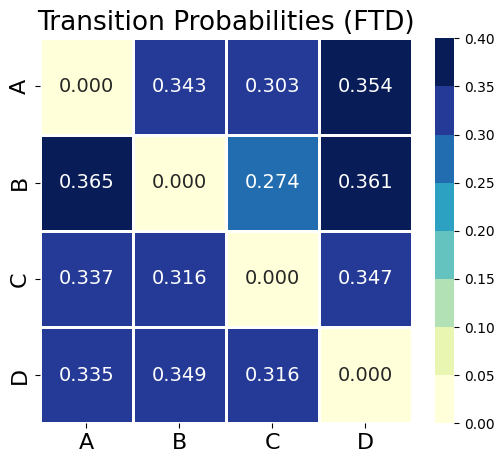

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

avg_transition = transition_prob_f.mean()

# Reshape into a 4x4 transition matrix
states = ["A", "B", "C", "D"]
transition_matrix = pd.DataFrame(
    avg_transition.values.reshape(4, 4),
    index=states,
    columns=states
)

# Define custom color levels at every 0.05 step
levels = np.arange(0, 0.45, 0.05)  # From 0 to slightly above 0.42 in 0.05 steps
cmap = plt.get_cmap("YlGnBu", len(levels) - 1)  # Discrete colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Apply color boundaries

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    transition_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=0.8,
    annot_kws={"size": 14}, norm=norm, cbar_kws={"ticks": levels}
)

# Adjust font sizes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transition Probabilities (FTD)", fontsize=19)

# Save the plot
plt.savefig("Transition_Probabilities_FTD.png", dpi=300, bbox_inches='tight')
plt.show()

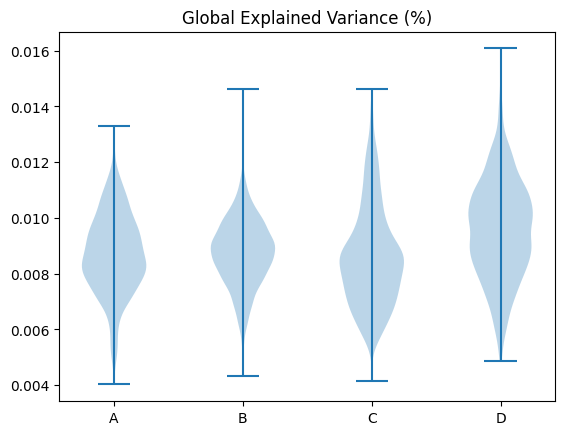

In [48]:
data = [
    [parameters['A_meandurs'], parameters['B_meandurs'], parameters['C_meandurs'], parameters['D_meandurs']]
    for parameters in ms_data_f
]

plt.violinplot(np.array(data))
plt.title("Global Explained Variance (%)")
plt.xticks(
    ticks=range(1, len(ModK.cluster_names) + 1),
    labels=ModK.cluster_names,
)
plt.show()

In [49]:
ms_data_f_df.head(10)

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,A_D,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C
0,0.638035,0.194205,32.652244,0.372997,0.011423,0.625193,0.094885,26.442308,0.219952,0.008318,...,0.374233,0.371212,0.196970,0.431818,0.418182,0.290909,0.290909,0.446667,0.346667,0.206667
1,0.625175,0.194752,31.325301,0.365060,0.011654,0.628502,0.113376,28.112450,0.254217,0.009043,...,0.397436,0.371429,0.235714,0.392857,0.514851,0.277228,0.207921,0.376812,0.398551,0.224638
2,0.646442,0.205500,33.145842,0.382081,0.011527,0.656500,0.128577,29.329048,0.252712,0.008616,...,0.353659,0.493151,0.150685,0.356164,0.407767,0.378641,0.213592,0.383459,0.406015,0.210526
3,0.625735,0.125677,33.039648,0.335202,0.010145,0.607027,0.070887,28.434121,0.255907,0.009000,...,0.460606,0.471831,0.140845,0.387324,0.341176,0.352941,0.305882,0.439490,0.388535,0.171975
4,0.628534,0.178157,32.076985,0.329190,0.010263,0.651792,0.149224,28.468324,0.285084,0.010014,...,0.396226,0.485915,0.218310,0.295775,0.336634,0.287129,0.376238,0.395833,0.430556,0.173611
5,0.646169,0.133761,31.475541,0.336006,0.010675,0.644045,0.081082,26.463512,0.236568,0.008939,...,0.363057,0.409091,0.287879,0.303030,0.440000,0.280000,0.280000,0.356061,0.416667,0.227273
6,0.650817,0.152245,29.859719,0.312625,0.010470,0.654059,0.127299,27.655311,0.256513,0.009275,...,0.422819,0.391304,0.217391,0.391304,0.358491,0.358491,0.283019,0.390411,0.356164,0.253425
7,0.628308,0.189069,33.079391,0.375702,0.011358,0.631397,0.099644,25.862069,0.216921,0.008388,...,0.432927,0.418605,0.217054,0.364341,0.500000,0.230000,0.270000,0.417808,0.397260,0.184932
8,0.613969,0.153531,31.450321,0.350561,0.011146,0.664152,0.152189,25.841346,0.250000,0.009674,...,0.445860,0.449612,0.232558,0.317829,0.441176,0.352941,0.205882,0.404580,0.412214,0.183206
9,0.643583,0.195145,29.943730,0.323553,0.010805,0.633263,0.113332,27.934084,0.256833,0.009194,...,0.322148,0.402878,0.287770,0.309353,0.361111,0.305556,0.333333,0.425197,0.362205,0.212598


In [50]:
ms_data_f_df['label'] = 2  # 2 For dementia

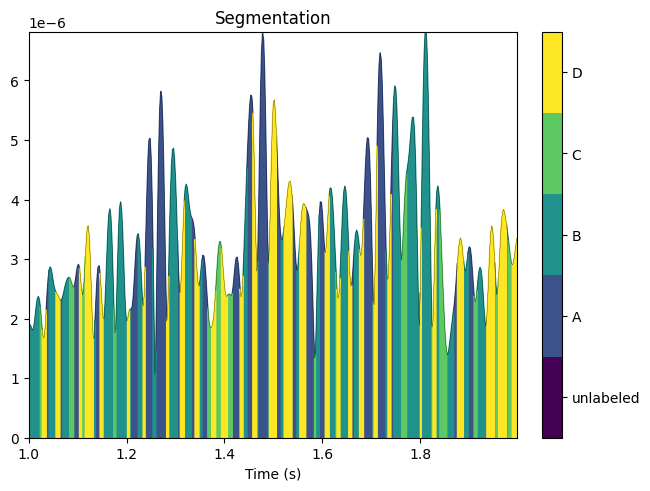

In [51]:
#for segmentation plot of a single patient
raw = mne.io.read_raw_eeglab("/kaggle/input/alzheimerderivatives/sub-080_task-eyesclosed_eeg.set", preload=True)
raw.pick("eeg")
raw.crop(0, 479.098)  # Crop the dataset to speed up computation taking 9 minutes
raw.set_eeg_reference("average")
raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)  # Apply band-pass filter (e.g., alpha band)
segmentation = ModK.predict(raw)
fig = segmentation.plot(tmin=1, tmax=2);
# Increase figure size
fig.set_size_inches(12, 8)  # Width: 12 inches, Height: 8 inches (adjust as needed)

# Save the plot to a file
fig.savefig("segmentation_plot_FTD.png", dpi=300)  # Save with high resolution (300 dpi)

# Optional: Show the plot
plt.show()


# Concatenate AD and Normal and FTD

In [52]:
# Combine the DataFrames
df = pd.concat([ms_data_df, ms_data_hc_df, ms_data_f_df], ignore_index=True)

In [53]:
df

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C,label
0,0.572685,0.066796,32.661290,0.216935,0.006642,0.625772,0.073567,29.032258,0.185081,0.006375,...,0.493056,0.326389,0.180556,0.322034,0.327684,0.350282,0.239130,0.210145,0.550725,1
1,0.605374,0.094844,34.068136,0.248096,0.007282,0.601817,0.059994,28.256513,0.164729,0.005830,...,0.482270,0.361702,0.156028,0.264865,0.335135,0.400000,0.346405,0.143791,0.509804,1
2,0.599487,0.079159,36.903329,0.236262,0.006402,0.616937,0.080912,33.493783,0.212194,0.006335,...,0.538922,0.275449,0.185629,0.237288,0.395480,0.367232,0.333333,0.250000,0.416667,1
3,0.558343,0.061351,34.040849,0.214257,0.006294,0.590509,0.056853,29.235082,0.168602,0.005767,...,0.520548,0.342466,0.136986,0.270718,0.331492,0.397790,0.302013,0.221477,0.476510,1
4,0.568635,0.043385,32.102729,0.180979,0.005638,0.561140,0.026623,26.685393,0.144462,0.005414,...,0.458647,0.360902,0.180451,0.266272,0.289941,0.443787,0.333333,0.185185,0.481481,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,0.602832,0.067505,25.030036,0.194634,0.007776,0.664883,0.131392,27.232679,0.245895,0.009029,...,0.264706,0.235294,0.500000,0.293578,0.284404,0.422018,0.356250,0.312500,0.331250,2
6551,0.592774,0.057384,24.096386,0.177108,0.007350,0.667537,0.138562,26.305221,0.240964,0.009160,...,0.320611,0.290076,0.389313,0.355769,0.221154,0.423077,0.266234,0.422078,0.311688,2
6552,0.579966,0.043628,20.858404,0.153630,0.007365,0.685346,0.152977,25.671881,0.279984,0.010906,...,0.226562,0.265625,0.507812,0.200000,0.323810,0.476190,0.362416,0.322148,0.315436,2
6553,0.597763,0.044259,21.268058,0.151685,0.007132,0.705126,0.183888,28.089888,0.287721,0.010243,...,0.280576,0.237410,0.482014,0.145631,0.368932,0.485437,0.320988,0.413580,0.265432,2


# Figure for Microstate

## AD And HC

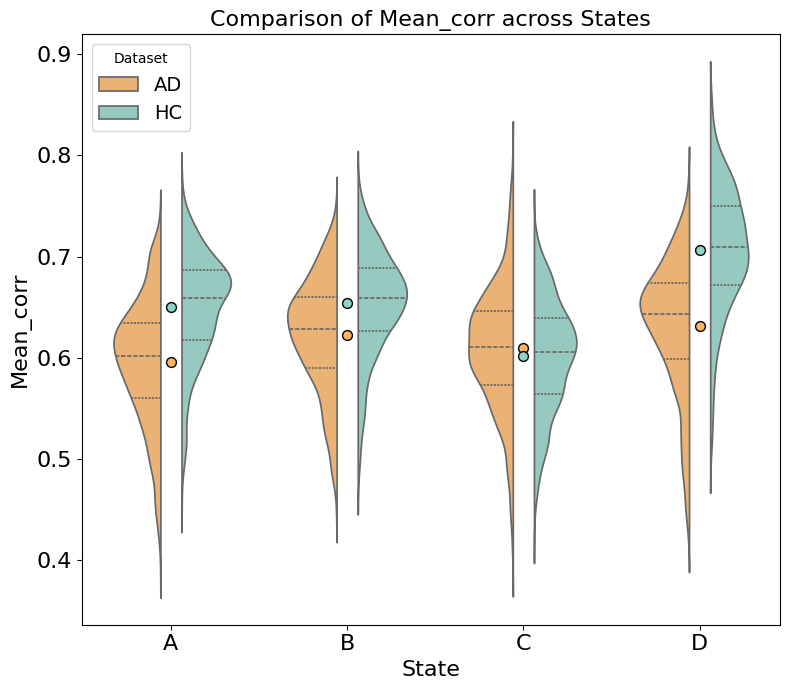

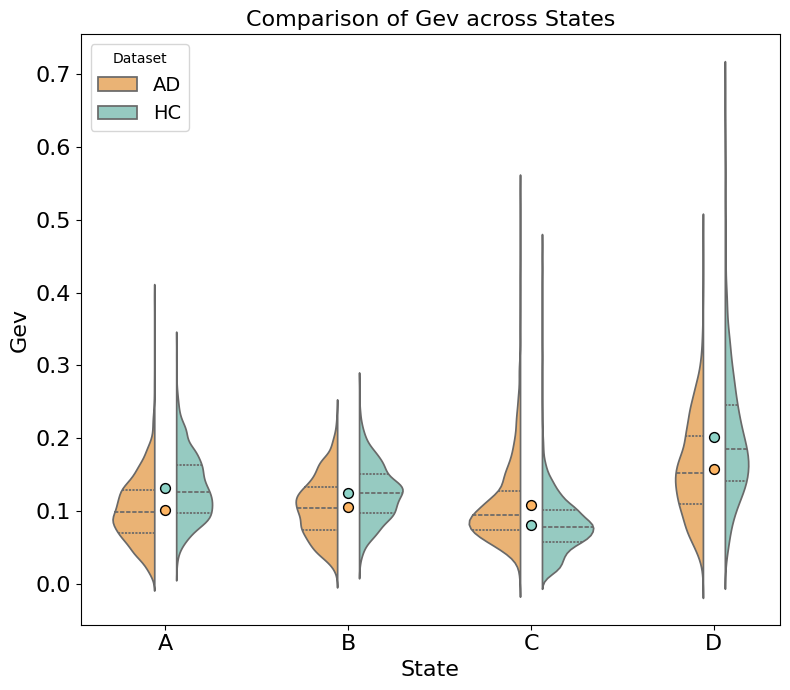

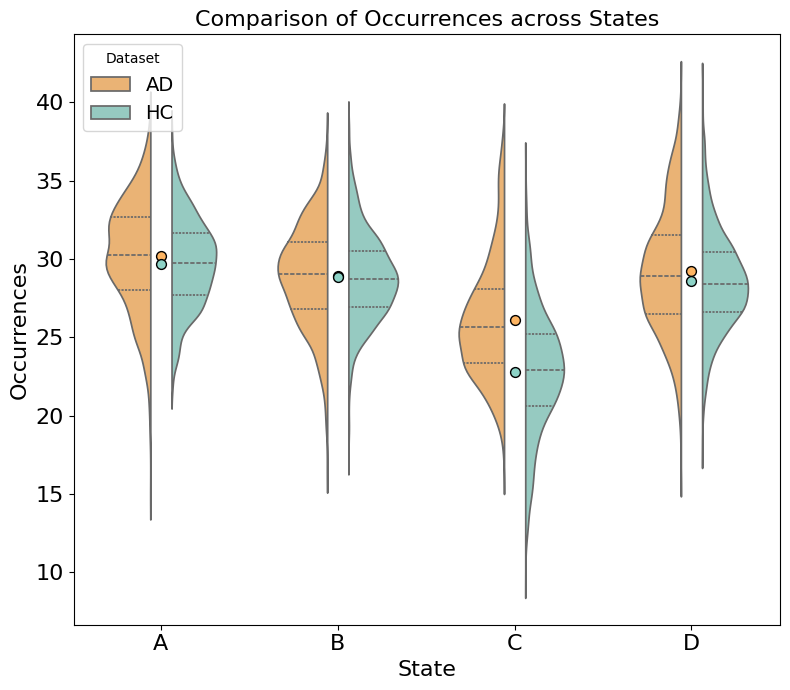

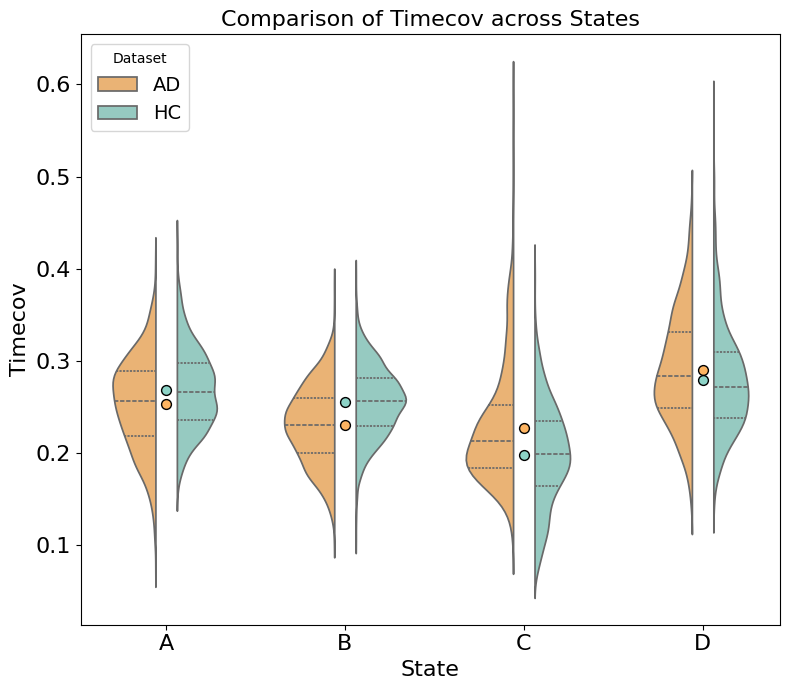

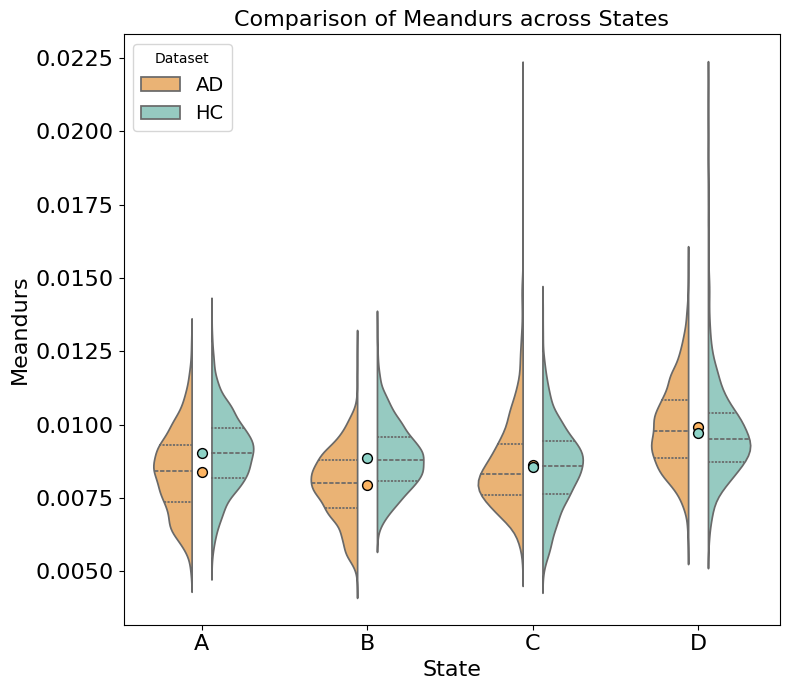

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create temporary copies of the dataframes with the 'Dataset' column added
ms_data_ad = ms_data_df.copy()
ms_data_ad['Dataset'] = 'AD'

ms_data_hc = ms_data_hc_df.copy()
ms_data_hc['Dataset'] = 'HC'

ms_data_f = ms_data_f_df.copy()
ms_data_f['Dataset'] = 'FTD'

# Combine the temporary datasets
combined_df = pd.concat([ms_data_ad, ms_data_hc])

# Define custom colors for each dataset
custom_palette = {
    'AD': '#fdb462',  # Blue
    'HC': '#8dd3c7',  # Orange
    # 'FTD': '#ffffb3',  # Green
}

# Define the parameters to plot
parameters_to_plot = ['mean_corr', 'gev', 'occurrences', 'timecov', 'meandurs']

# Iterate through each parameter to create a plot
for parameter in parameters_to_plot:
    # Select columns for this parameter (e.g., 'A_gev', 'B_gev', 'C_gev', 'D_gev')
    columns_to_plot = [f"{state}_{parameter}" for state in ['A', 'B', 'C', 'D']]
    
    # Melt the dataframe to get a long format for plotting
    melted_df = combined_df.melt(
        id_vars='Dataset',
        value_vars=columns_to_plot,
        var_name='State',
        value_name='Value'
    )
    
    # Simplify the 'State' column to remove '_parameter' (e.g., '_gev')
    melted_df['State'] = melted_df['State'].str.replace(f"_{parameter}", '', regex=True)

    # Create a violin plot
    plt.figure(figsize=(8, 7))
    sns.violinplot(data=melted_df, x='State', y='Value', hue='Dataset', split=True, gap=.3, palette=custom_palette, inner="quart")

    # Overlay the mean as points
    means = melted_df.groupby(['State', 'Dataset'])['Value'].mean().reset_index()
    for dataset, color in custom_palette.items():
        subset_means = means[means['Dataset'] == dataset]
        plt.scatter(
            x=subset_means['State'].apply(lambda x: ['A', 'B', 'C', 'D'].index(x)),  # X-axis positions for states
            y=subset_means['Value'],
            # label=f'{dataset} Mean',
            color=color,
            edgecolor='black',
            s=50,  # Size of points
            zorder=10,  # Ensure points are on top
            label=None  # Suppress scatter point labels
        )

    # Customize the plot
    plt.title(f"Comparison of {parameter.capitalize()} across States", fontsize=16)
    plt.xlabel('State', fontsize=16)
    plt.ylabel(parameter.capitalize(), fontsize=16)
    plt.tick_params(axis='x', labelsize=16)  # Increase font size for y-axis ticks
    plt.tick_params(axis='y', labelsize=16)  # Increase font size for y-axis ticks
    plt.legend(title='Dataset', loc='upper left', fontsize=14)
    plt.tight_layout()

    
    # Save and display the plot
    plot_filename = f"AD vs HC Comparison_of_{parameter}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # Save as a high-resolution image
    plt.show()


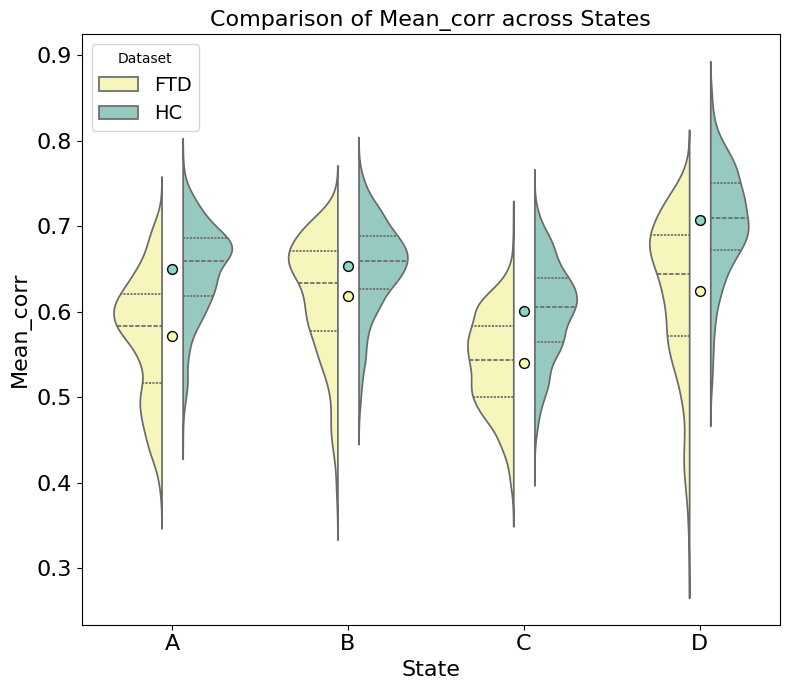

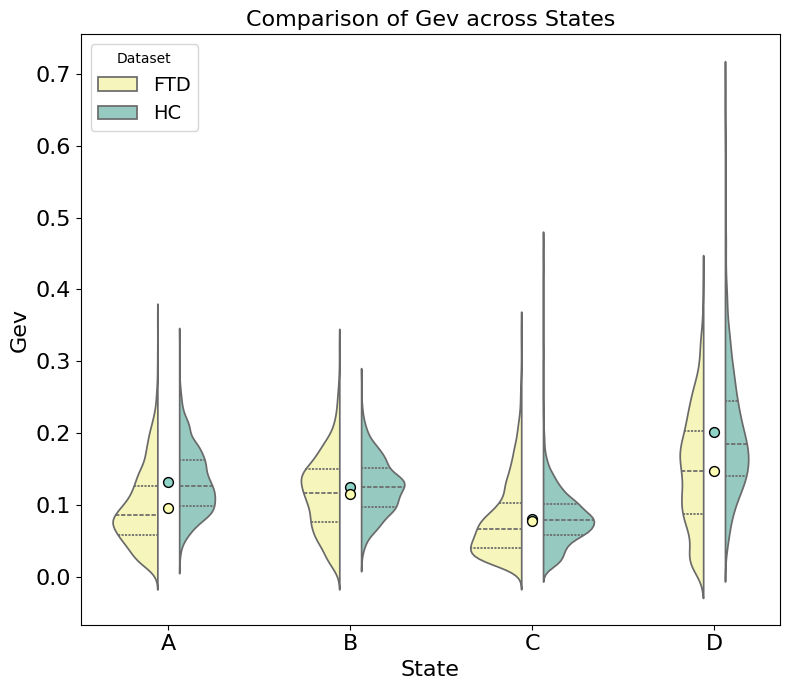

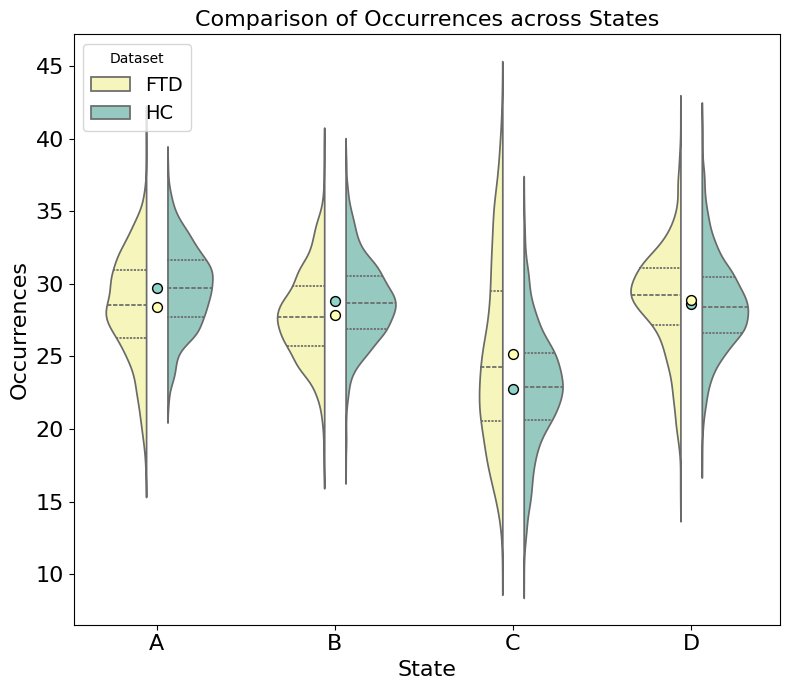

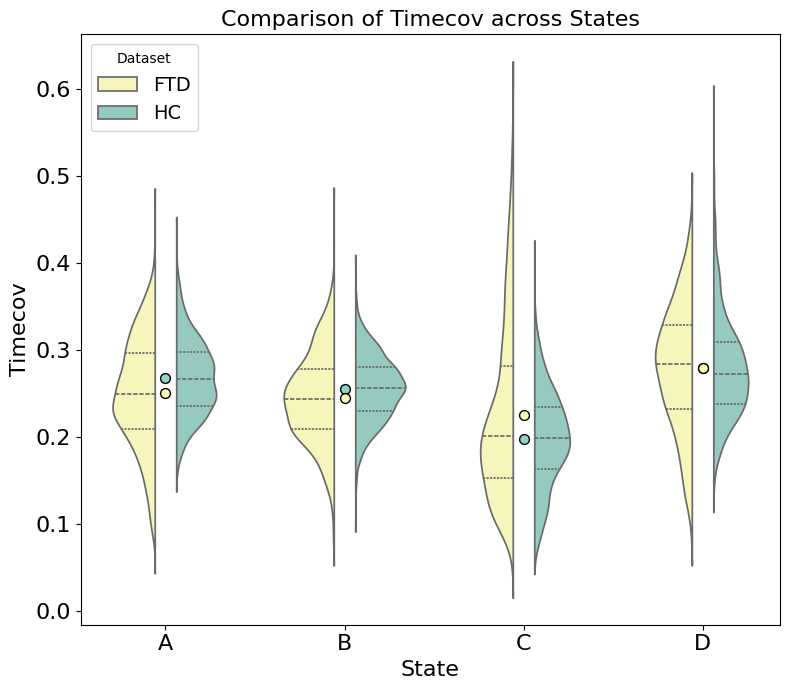

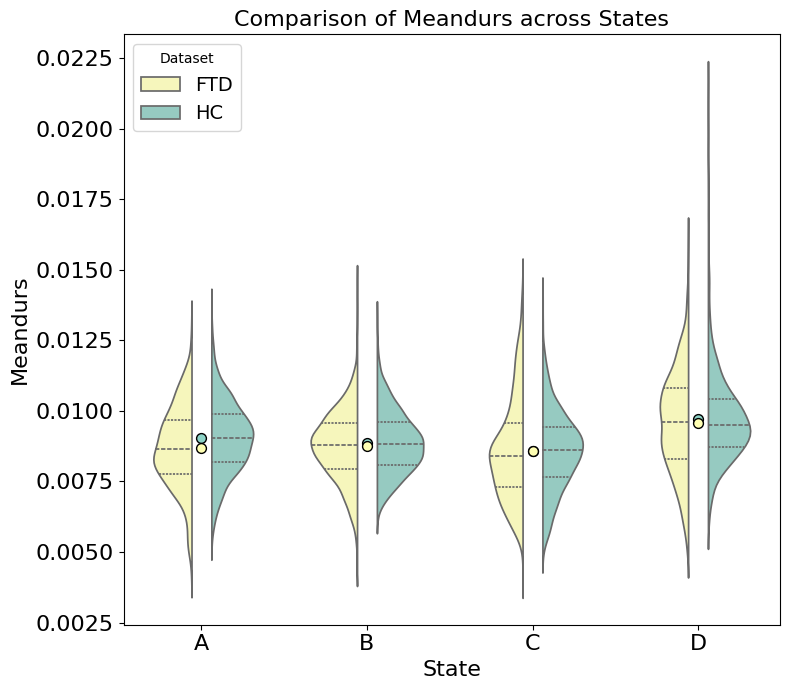

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create temporary copies of the dataframes with the 'Dataset' column added
ms_data_ad = ms_data_df.copy()
ms_data_ad['Dataset'] = 'AD'

ms_data_hc = ms_data_hc_df.copy()
ms_data_hc['Dataset'] = 'HC'

ms_data_f = ms_data_f_df.copy()
ms_data_f['Dataset'] = 'FTD'

# Combine the temporary datasets
combined_df = pd.concat([ms_data_f, ms_data_hc])

# Define custom colors for each dataset
custom_palette = {
    # 'AD': '#fb8072',  # Blue
    'HC': '#8dd3c7',  # Orange
    'FTD': '#ffffb3',  # Green
}


# Define the parameters to plot
parameters_to_plot = ['mean_corr', 'gev', 'occurrences', 'timecov', 'meandurs']

# Iterate through each parameter to create a plot
for parameter in parameters_to_plot:
    # Select columns for this parameter (e.g., 'A_gev', 'B_gev', 'C_gev', 'D_gev')
    columns_to_plot = [f"{state}_{parameter}" for state in ['A', 'B', 'C', 'D']]
    
    # Melt the dataframe to get a long format for plotting
    melted_df = combined_df.melt(
        id_vars='Dataset',
        value_vars=columns_to_plot,
        var_name='State',
        value_name='Value'
    )
    
    # Simplify the 'State' column to remove '_parameter' (e.g., '_gev')
    melted_df['State'] = melted_df['State'].str.replace(f"_{parameter}", '', regex=True)

    # Create a violin plot
    plt.figure(figsize=(8, 7))
    sns.violinplot(data=melted_df, x='State', y='Value', hue='Dataset', split=True, gap=.3, palette=custom_palette, inner="quart")

    # Overlay the mean as points
    means = melted_df.groupby(['State', 'Dataset'])['Value'].mean().reset_index()
    for dataset, color in custom_palette.items():
        subset_means = means[means['Dataset'] == dataset]
        plt.scatter(
            x=subset_means['State'].apply(lambda x: ['A', 'B', 'C', 'D'].index(x)),  # X-axis positions for states
            y=subset_means['Value'],
            # label=f'{dataset} Mean',
            color=color,
            edgecolor='black',
            s=50,  # Size of points
            zorder=10,  # Ensure points are on top
            label=None  # Suppress scatter point labels
        )

    # Customize the plot
    plt.title(f"Comparison of {parameter.capitalize()} across States", fontsize=16)
    plt.xlabel('State', fontsize=16)
    plt.ylabel(parameter.capitalize(), fontsize=16)
    plt.tick_params(axis='x', labelsize=16)  # Increase font size for y-axis ticks
    plt.tick_params(axis='y', labelsize=16)  # Increase font size for y-axis ticks
    plt.legend(title='Dataset', loc='upper left', fontsize=14)
    plt.tight_layout()

    # Save and display the plot
    plot_filename = f"FTD vs HC Comparison_of_{parameter}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # Save as a high-resolution image
    plt.show()


# Train test split

In [56]:
correlations = df.corr(method = 'pearson')
print(correlations['label'].sort_values(ascending= False).to_string())

label            1.000000
D_C              0.230897
A_C              0.215865
C_occurrences    0.196980
B_D              0.156909
C_timecov        0.148452
C_A              0.111051
B_C              0.058769
D_occurrences    0.033975
C_meandurs       0.007859
D_timecov        0.003789
unlabeled       -0.007137
C_gev           -0.021322
D_meandurs      -0.040406
C_D             -0.042904
B_meandurs      -0.043645
D_B             -0.064648
C_B             -0.075065
A_D             -0.092255
B_gev           -0.092493
B_timecov       -0.093171
A_meandurs      -0.100221
B_occurrences   -0.131910
A_timecov       -0.136322
A_occurrences   -0.153428
A_B             -0.174074
D_A             -0.230103
B_mean_corr     -0.231562
B_A             -0.235626
D_gev           -0.264971
A_gev           -0.299793
C_mean_corr     -0.381908
D_mean_corr     -0.413045
A_mean_corr     -0.457113


In [57]:
df= df.drop(columns = ['unlabeled']) #dropping unnecessary columns

In [58]:
# df = output_df

from sklearn.preprocessing import LabelEncoder

df_features= df.drop(columns = ['label'])
df_label = df['label']

X= df_features
y = df_label

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
MinMaxScaler_df = scaler1.fit_transform( X )       
MinMaxScaler_df

array([[-0.47230673, -0.86482559,  0.95731475, ..., -1.75497087,
        -1.65378142,  2.72420472],
       [-0.00540523, -0.29931133,  1.37460255, ..., -0.19356823,
        -2.55032613,  2.2654004 ],
       [-0.08948817, -0.61555534,  2.21555565, ..., -0.38383186,
        -1.11527866,  1.22114265],
       ...,
       [-0.36830605, -1.33193899, -2.54356651, ...,  0.0394728 ,
        -0.14045396,  0.08614404],
       [-0.11410536, -1.31921015, -2.42205802, ..., -0.56352529,
         1.09493974, -0.47450393],
       [-0.19842771, -1.36894407, -2.72203359, ..., -0.93050484,
         1.0256318 , -0.13430235]])

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(MinMaxScaler_df, y, test_size=0.3, random_state=42 )

print(" Train data shape X :", X_train.shape)
print(" Train data shape y:", y_train.shape)

print(" Test data shape X :", X_test.shape)
print(" Test data shape y :", y_test.shape)

 Train data shape X : (4588, 32)
 Train data shape y: (4588,)
 Test data shape X : (1967, 32)
 Test data shape y : (1967,)


In [60]:
# Convert scaled features back to a DataFrame with original column names
scaled_df = pd.DataFrame(MinMaxScaler_df, columns=X.columns)

scaled_df.head()  # Preview the scaled DataFrame

,A_mean_corr,A_gev,A_occurrences,A_timecov,A_meandurs,B_mean_corr,B_gev,B_occurrences,B_timecov,B_meandurs,...,A_D,B_A,B_C,B_D,C_A,C_B,C_D,D_A,D_B,D_C
0,-0.472307,-0.864826,0.957315,-0.752011,-1.476348,-0.098429,-0.920184,0.167517,-1.284142,-1.736550,...,-0.625656,1.381813,0.660939,-1.916637,0.152719,0.069174,-0.188131,-1.754971,-1.653781,2.724205
1,-0.005405,-0.299311,1.374603,-0.167198,-1.016996,-0.488115,-1.221922,-0.084952,-1.731688,-2.177146,...,-0.298655,1.226887,1.128315,-2.238311,-0.659710,0.195376,0.442540,-0.193568,-2.550326,2.265400
2,-0.089488,-0.615555,2.215556,-0.389307,-1.648361,-0.242142,-0.756903,1.619539,-0.687885,-1.768609,...,-0.461566,2.040619,-0.013256,-1.850103,-1.051603,1.217401,0.026870,-0.383832,-1.115279,1.221143
3,-0.677161,-0.974597,1.366509,-0.802278,-1.725871,-0.672080,-1.291760,0.233527,-1.646519,-2.227786,...,-0.327537,1.776701,0.873719,-2.488047,-0.576528,0.133669,0.414507,-0.839698,-1.500674,1.892109
4,-0.530154,-1.336833,0.791639,-1.426827,-2.196873,-1.149846,-1.963802,-0.596280,-2.177387,-2.513528,...,0.559462,0.887579,1.117728,-1.918007,-0.639710,-0.570051,0.997982,-0.383832,-1.991026,1.947848


In [61]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [62]:
# Initializing classifiers with default parameters
classifiers = {
    # 'KNN': KNeighborsClassifier(),
    # 'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'Logistic Regression': LogisticRegression(),
    # 'SVM': SVC(),
    # 'Naive Bayes': GaussianNB(),
    # 'AdaBoost': AdaBoostClassifier(),
    # 'Gradient Boosting': GradientBoostingClassifier()
}

# Defining hyperparameter search spaces for each classifier
param_grids = {
    # 'KNN': {'n_neighbors': np.arange(1, 11)},
    # 'Decision Tree': {'max_depth': np.arange(1, 11), 'criterion': ['gini', 'entropy']},
    'Random Forest': {'n_estimators': [100, 200,250, 300,400], 'max_depth': np.arange(7, 20), 'criterion': ['gini', 'entropy']},
    # 'Logistic Regression': {'C': np.logspace(-2, 2, 5), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    # 'SVM': {'C': np.logspace(-2, 2, 5), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']},
    # 'Naive Bayes': {},
    # 'AdaBoost': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.001, 0.01, 0.1, 1]},
    # 'Gradient Boosting': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [ 0.01, 0.1, 0.5, 1], 'max_depth': np.arange(1, 11)}
}

# Performing hyperparameter tuning for each classifier using GridSearchCV
best_classifiers = {}
for classifier_name, classifier in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grids[classifier_name], scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_classifiers[classifier_name] = grid_search.best_estimator_
    print(f"{classifier_name}: Best parameters - {grid_search.best_params_}, Best score - {grid_search.best_score_}")

Random Forest: Best parameters - {'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 250}, Best score - 0.9149939534762167


In [63]:
# Testing the best models on test data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Testing models on the test data...")
for classifier_name, best_model in best_classifiers.items():
    # Predicting on the test data
    y_pred = best_model.predict(X_test)
    
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)*100
    print(f"{classifier_name}:")
    print(f"Accuracy on test data: {accuracy:.4f}")
    
    # # Compute and display classification report in decimals
    # report = classification_report(y_test, y_pred, output_dict=True)
    # report_df = pd.DataFrame(report).transpose()
    # print(report_df.round(4)*100)
    
    # # Confusion matrix
    # print("\nConfusion Matrix:")
    # print(confusion_matrix(y_test, y_pred))
    # print("\n" + "-"*50 + "\n")


Testing models on the test data...
Random Forest:
Accuracy on test data: 92.9334


              precision  recall  f1-score    support
0                 96.38   96.97     96.67   65900.00
1                 98.38   97.94     98.16   68100.00
2                 96.33   96.17     96.25   62700.00
accuracy          97.05   97.05     97.05      97.05
macro avg         97.03   97.03     97.03  196700.00
weighted avg      97.05   97.05     97.05  196700.00
Train Accuracy: 99.237
Test Accuracy: 97.05
Multiclass AUC Score: 0.9978


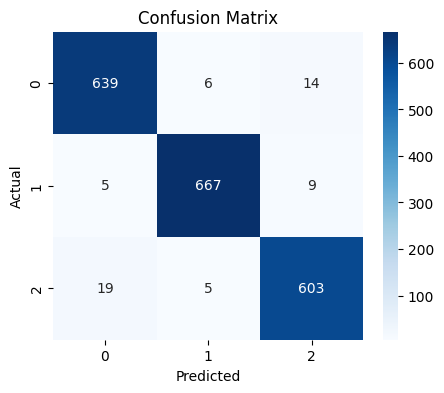

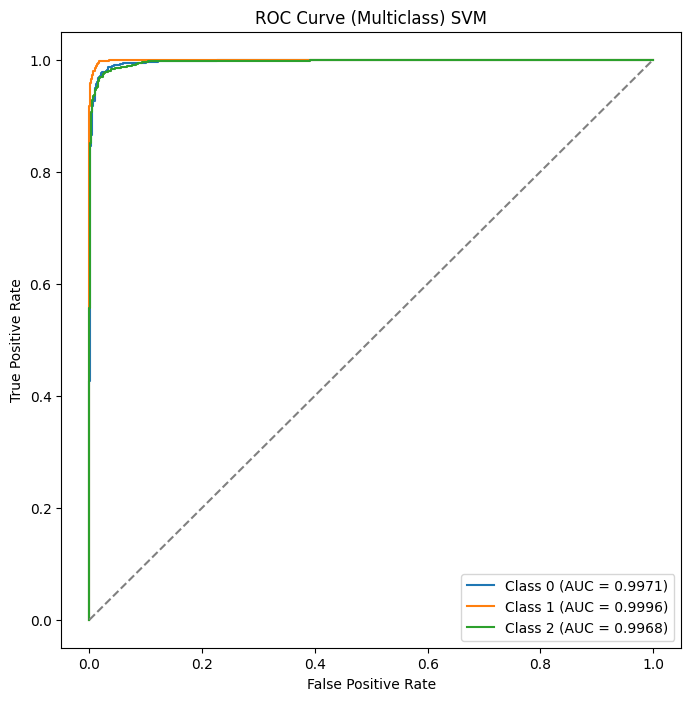

In [64]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the SVM classifier
svm_classifier = SVC(C=10, gamma='scale', kernel='rbf',  probability=True)  # You can also try other kernels like 'rbf'

# Train the model
svm_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_SVM = svm_classifier.predict(X_test)

# Compute and display classification report in decimals
report = classification_report(y_test, y_pred_SVM, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(4)*100)

# Display train and test accuracy
print("Train Accuracy:", accuracy_score(svm_classifier.predict(X_train), y_train).round(5)*100)
print("Test Accuracy:", accuracy_score(y_pred_SVM, y_test).round(4)*100)

y_probs_svm = svm_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass
auc_score = roc_auc_score(y_test, y_probs_svm, multi_class='ovr')
print(f"Multiclass AUC Score: {auc_score:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_SVM)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(svm_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_svm[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_svm[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) SVM')
plt.legend(loc='lower right')
plt.show()

              precision  recall  f1-score    support
0                 89.50   89.23     89.36   65900.00
1                 94.34   95.45     94.89   68100.00
2                 91.95   91.07     91.51   62700.00
accuracy          91.97   91.97     91.97      91.97
macro avg         91.93   91.91     91.92  196700.00
weighted avg      91.96   91.97     91.96  196700.00
Train Accuracy: 99.67
Test Accuracy: 91.97
Multiclass AUC Score: 0.9858


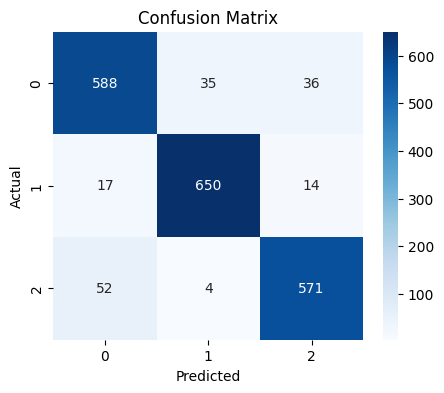

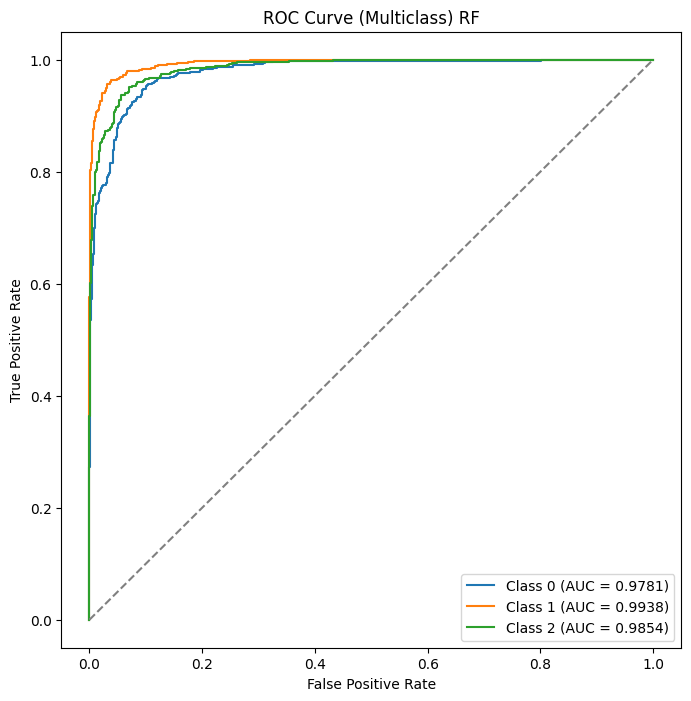

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(criterion= 'entropy', max_depth= 10, n_estimators= 200 )

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_RF = rf_classifier.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred_RF, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(4)*100)

print("Train Accuracy:", accuracy_score(rf_classifier.predict(X_train), y_train).round(4)*100)
print("Test Accuracy:", accuracy_score(y_pred_RF, y_test).round(4)*100)

y_probs_rf = rf_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass
auc_score = roc_auc_score(y_test, y_probs_rf, multi_class='ovr')
print(f"Multiclass AUC Score: {auc_score:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(rf_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_rf[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_rf[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) RF')
plt.legend(loc='lower right')
plt.show()

              precision  recall  f1-score    support
0                 86.03   88.77     87.38   65900.00
1                 95.56   91.63     93.55   68100.00
2                 90.06   91.07     90.56   62700.00
accuracy          90.49   90.49     90.49      90.49
macro avg         90.55   90.49     90.50  196700.00
weighted avg      90.61   90.49     90.53  196700.00
Train Accuracy: 92.65
Test Accuracy: 90.49000000000001
Multiclass AUC Score: 0.9792


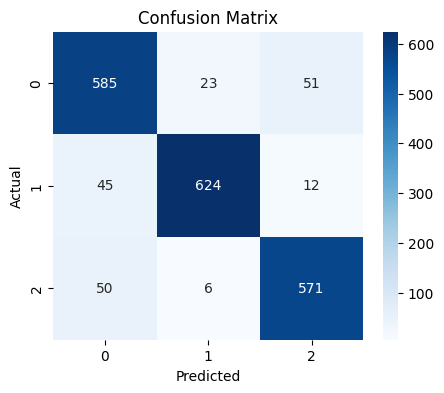

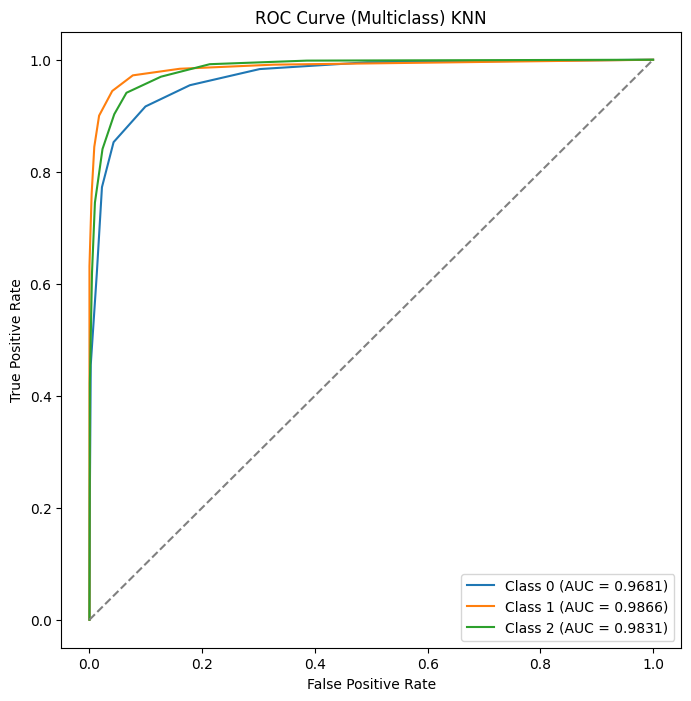

In [66]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=9)

# Train the model
knn_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_KNN = knn_classifier.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred_KNN, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(4)*100)
print("Train Accuracy:", accuracy_score(knn_classifier.predict(X_train), y_train).round(4)*100)
print("Test Accuracy:", accuracy_score(y_pred_KNN, y_test).round(4)*100)

y_probs_knn = knn_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass
auc_score = roc_auc_score(y_test, y_probs_knn, multi_class='ovr')
print(f"Multiclass AUC Score: {auc_score:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_KNN)
# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(knn_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_knn[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_knn[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) KNN')
plt.legend(loc='lower right')
plt.show()

              precision  recall  f1-score     support
0                76.061  76.176    76.118   65900.000
1                84.948  83.700    84.320   68100.000
2                80.031  81.180    80.602   62700.000
accuracy         80.376  80.376    80.376      80.376
macro avg        80.347  80.352    80.347  196700.000
weighted avg     80.403  80.376    80.387  196700.000
Train Accuracy: 95.25
Test Accuracy: 80.38
Multiclass AUC Score: 0.8830


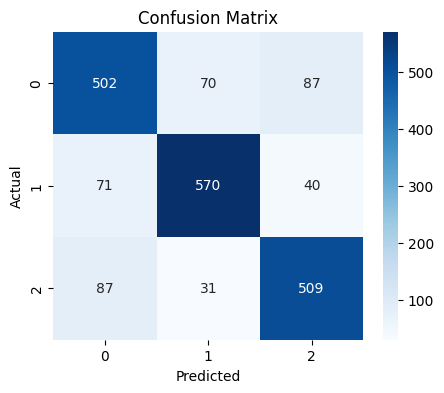

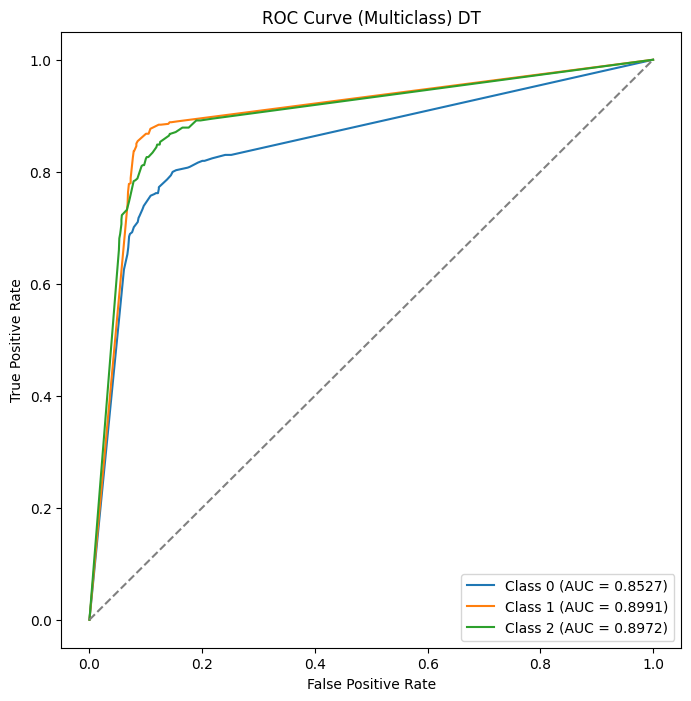

In [67]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=10)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_DT = dt_classifier.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred_DT, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(5)*100)
print("Train Accuracy:", accuracy_score(dt_classifier.predict(X_train), y_train).round(4)*100)
print("Test Accuracy:", accuracy_score(y_pred_DT, y_test).round(4)*100)

y_probs_dt = dt_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass
auc_score = roc_auc_score(y_test, y_probs_dt, multi_class='ovr')
print(f"Multiclass AUC Score: {auc_score:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_DT)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dt_classifier.classes_, yticklabels=dt_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(dt_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_dt[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_dt[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) DT')
plt.legend(loc='lower right')
plt.show()

              precision  recall  f1-score     support
0                94.545  94.689    94.617   65900.000
1                97.657  97.944    97.801   68100.000
2                94.712  94.258    94.484   62700.000
accuracy         95.679  95.679    95.679      95.679
macro avg        95.638  95.630    95.634  196700.000
weighted avg     95.676  95.679    95.677  196700.000
Train Accuracy: 95.53
Test Accuracy: 95.67999999999999
AUC Score (Macro-Averaged): 0.9937


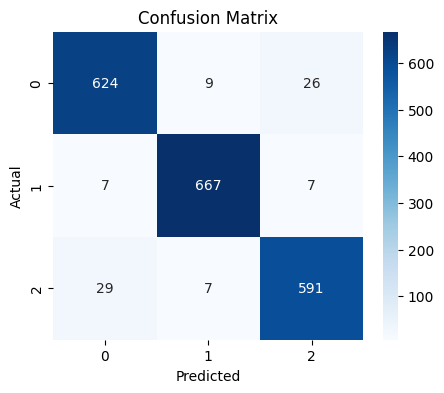

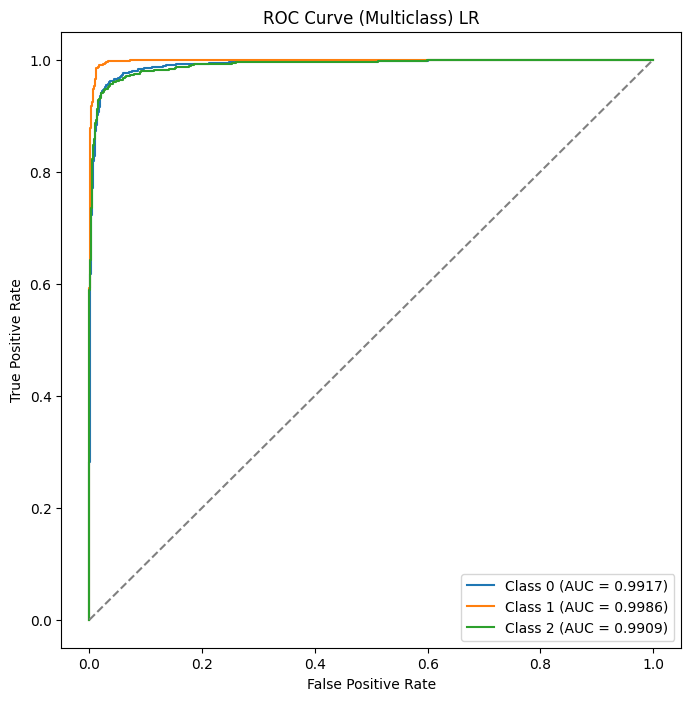

In [68]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(C=10, solver='liblinear')

# Train the model
lr_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_LR = lr_classifier.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred_LR, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(5)*100)
print("Train Accuracy:", accuracy_score(lr_classifier.predict(X_train), y_train).round(4)*100)
print("Test Accuracy:", accuracy_score(y_pred_LR, y_test).round(4)*100)

y_probs_lr = lr_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass
auc_score = roc_auc_score(y_test, y_probs_lr, multi_class='ovr')
print("AUC Score (Macro-Averaged):", round(auc_score, 4))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_LR)
# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr_classifier.classes_, yticklabels=lr_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(lr_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_lr[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_lr[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) LR')
plt.legend(loc='lower right')
plt.show()

              precision  recall  f1-score     support
0                90.108  88.467    89.280   65900.000
1                99.195  90.455    94.624   68100.000
2                84.692  94.418    89.291   62700.000
accuracy         91.052  91.052    91.052      91.052
macro avg        91.332  91.113    91.065  196700.000
weighted avg     91.528  91.052    91.134  196700.000
Train Accuracy: 94.12
Test Accuracy: 91.05
AUC Score (Macro-Averaged): 0.9587


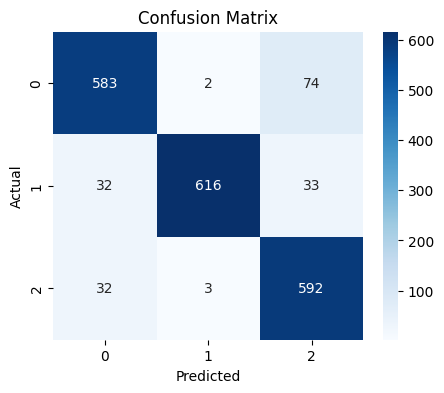

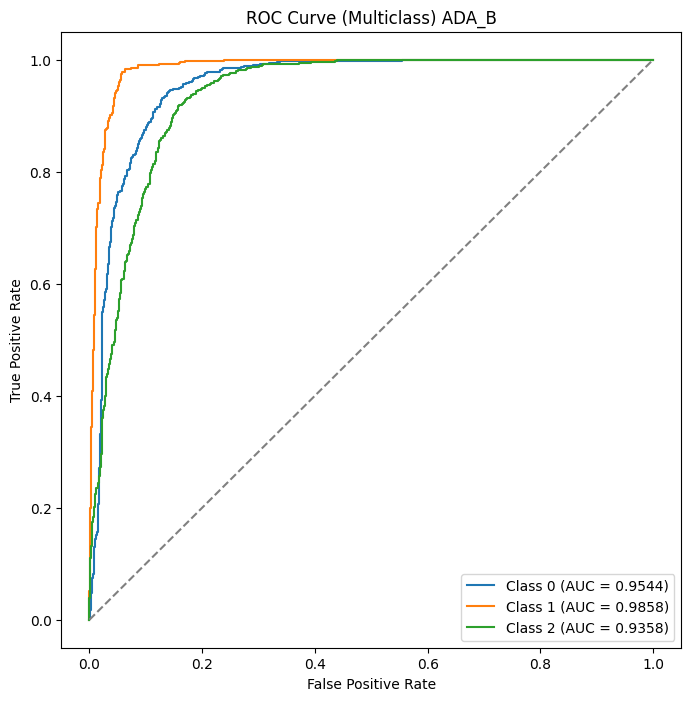

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Initialize the AdaBoost classifier
ada_classifier = AdaBoostClassifier(n_estimators=200, learning_rate=1)

# Train the model
ada_classifier.fit(X_train, y_train)

# Predict on test data
y_pred_Ada = ada_classifier.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred_Ada, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(5)*100)
print("Train Accuracy:", accuracy_score(ada_classifier.predict(X_train), y_train).round(4)*100)
print("Test Accuracy:", accuracy_score(y_pred_Ada, y_test).round(4)*100)

y_probs_ada = ada_classifier.predict_proba(X_test)
# Calculate AUC score for multiclass

auc_score = roc_auc_score(y_test, y_probs_ada, multi_class='ovr')
print("AUC Score (Macro-Averaged):", round(auc_score, 4))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_Ada)
# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=ada_classifier.classes_, yticklabels=ada_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve for each class
plt.figure(figsize=(8, 8))
for i, class_label in enumerate(ada_classifier.classes_):
    fpr, tpr, _ = roc_curve((y_test == class_label).astype(int), y_probs_ada[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score((y_test == class_label).astype(int), y_probs_ada[:, i]):.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass) ADA_B')
plt.legend(loc='lower right')
plt.show()